# Exploratory analysis and fairness metrics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline


In [111]:
math_data = pd.read_csv('student-mat.csv', sep=';')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(f"Math dataset shape: {math_data.shape}")
math_data.head()

Math dataset shape: (395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


In [3]:
print(math_data['G3'].describe())

# Pass if grade is 10 or higher
math_data['passed'] = math_data['G3'] >= 10


count    395.000000
mean      10.415190
std        4.581443
min        0.000000
25%        8.000000
50%       11.000000
75%       14.000000
max       20.000000
Name: G3, dtype: float64


/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Math Final Grade Distribution')

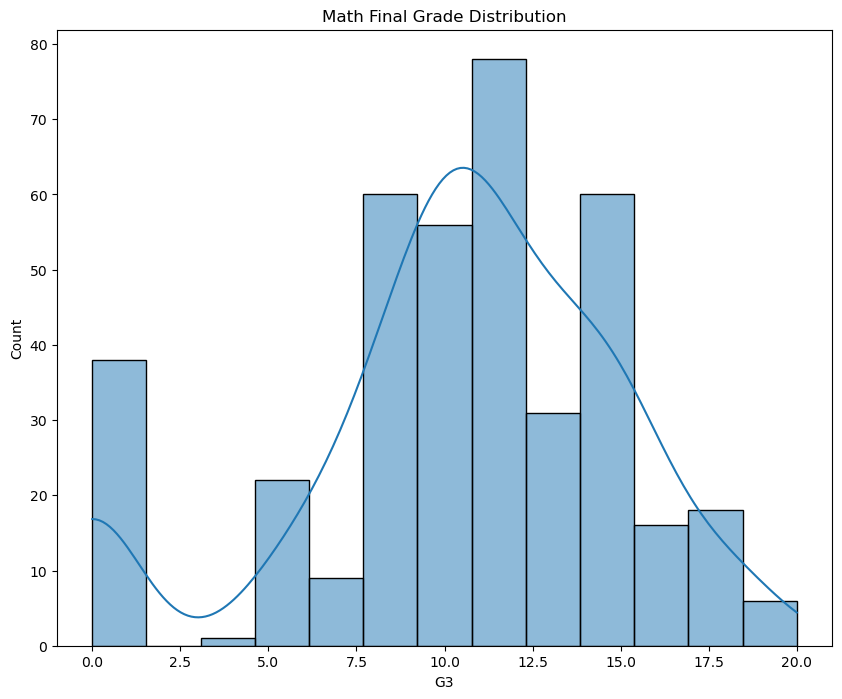

In [4]:
# Get grade distributions of all math students

plt.figure(figsize=(10, 8))
sns.histplot(data=math_data, x='G3', kde=True)
plt.title('Math Final Grade Distribution')

Text(0.5, 1.0, 'Math Grades by Gender')

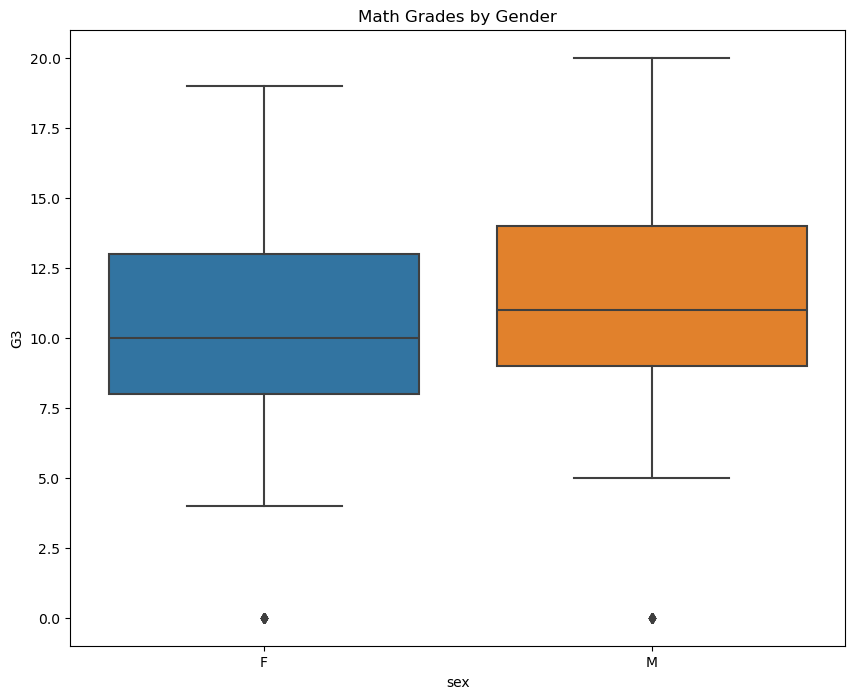

In [5]:
# Are there any differences in gender?

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x='sex', y='G3', data=math_data)
plt.title('Math Grades by Gender')

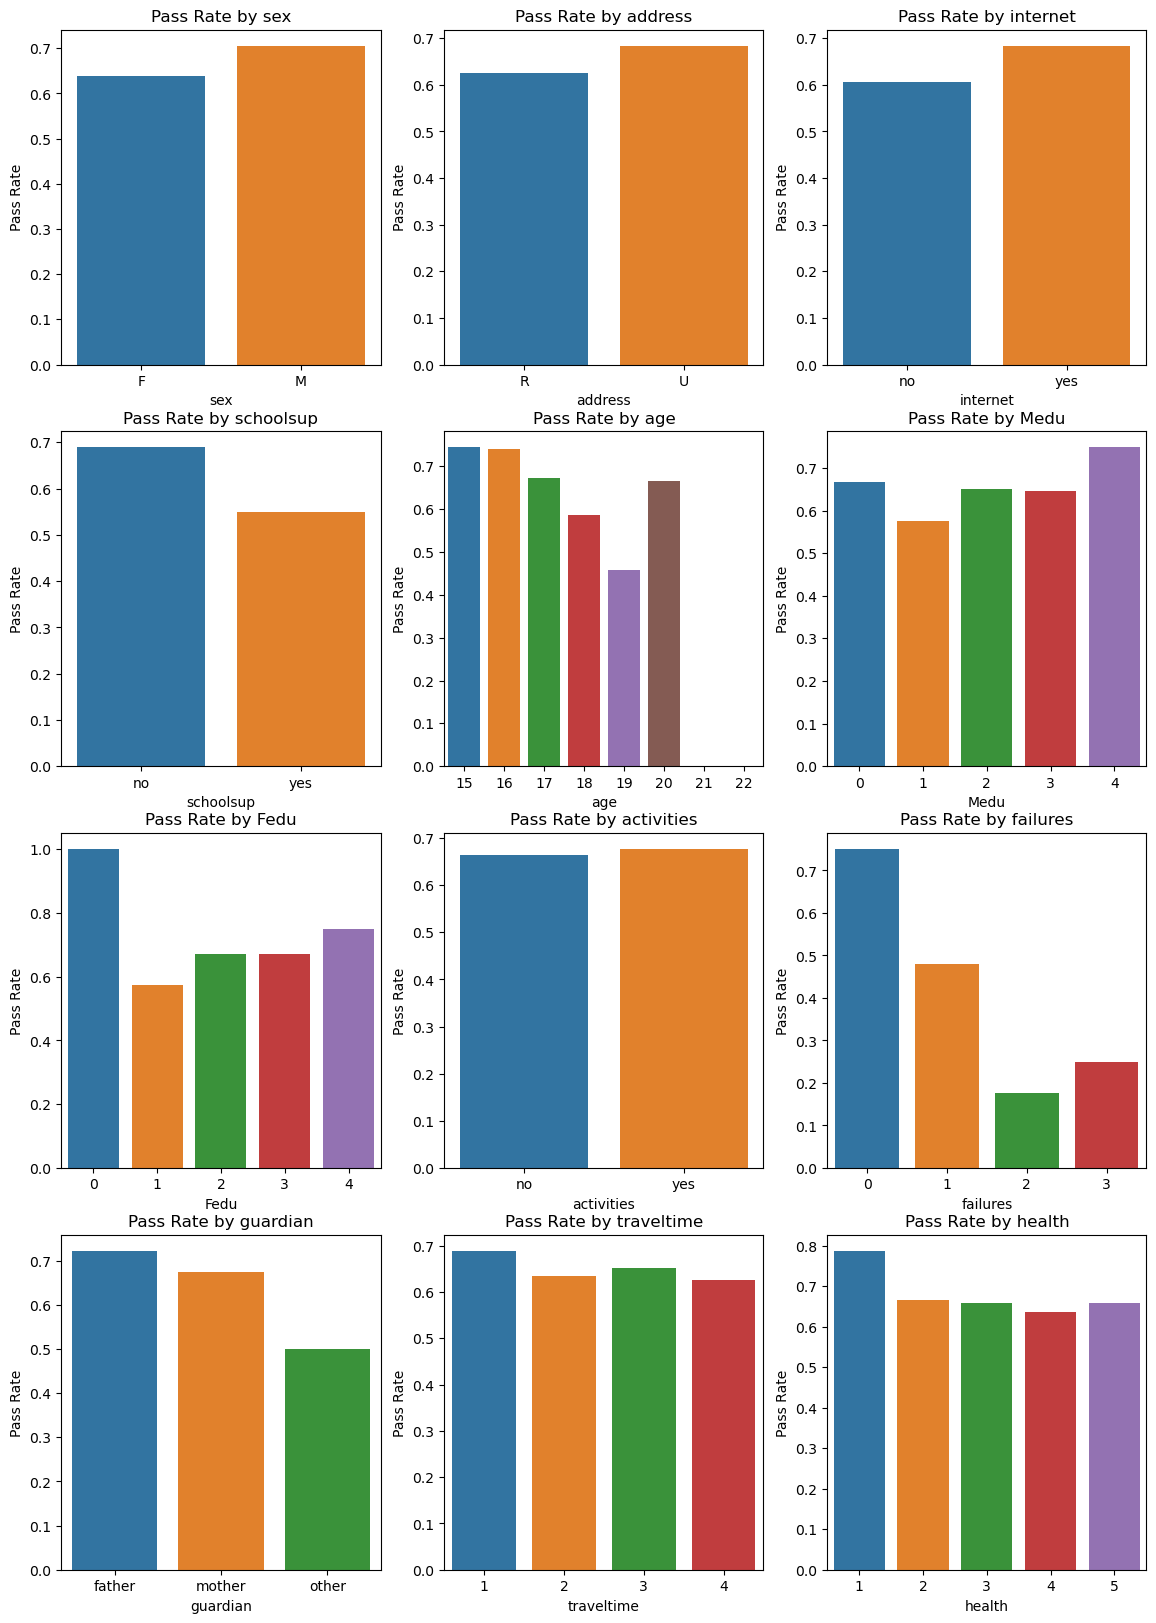

In [6]:
# Check for sensitive attributes - gender, socioeconomic status, etc
sensitive_attrs = ['sex', 'address', 'internet', 'schoolsup', 'age', 'Medu', 'Fedu', 'activities', 'failures',
                   'guardian', 'traveltime', 'health']
fig, axes = plt.subplots(4, 3, figsize=(14, 20))
axes = axes.flatten()

for i, attr in enumerate(sensitive_attrs):
    pass_rates = math_data.groupby(attr)['passed'].mean().reset_index()
    
    sns.barplot(x=attr, y='passed', data=pass_rates, ax=axes[i])
    axes[i].set_title(f'Pass Rate by {attr}')
    axes[i].set_ylabel('Pass Rate')    

Text(0.5, 1.0, 'Correlation Between Key Features')

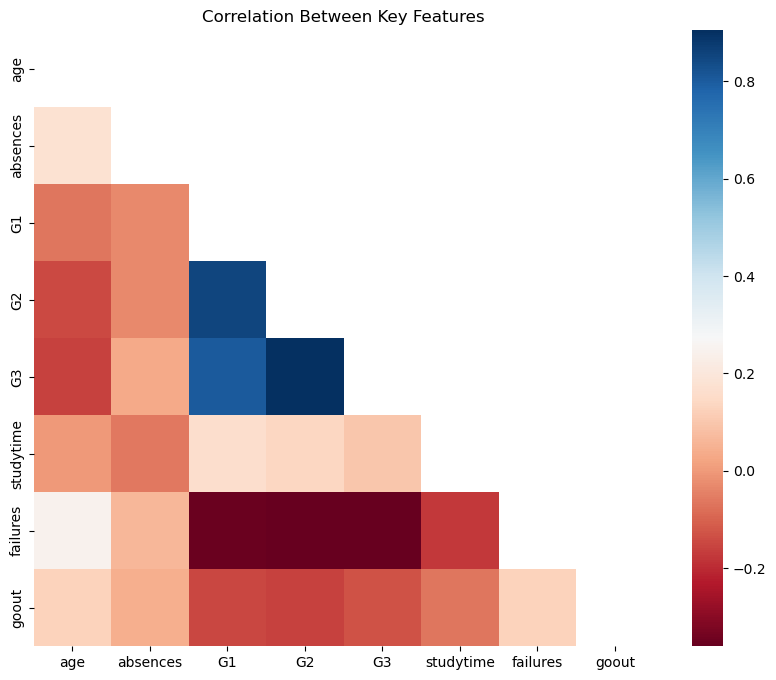

In [7]:
features = ['age', 'absences', 'G1', 'G2', 'G3', 'studytime', 'failures', 'goout']
plt.figure(figsize=(10, 8))
corr = math_data[features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='RdBu')
plt.title('Correlation Between Key Features')

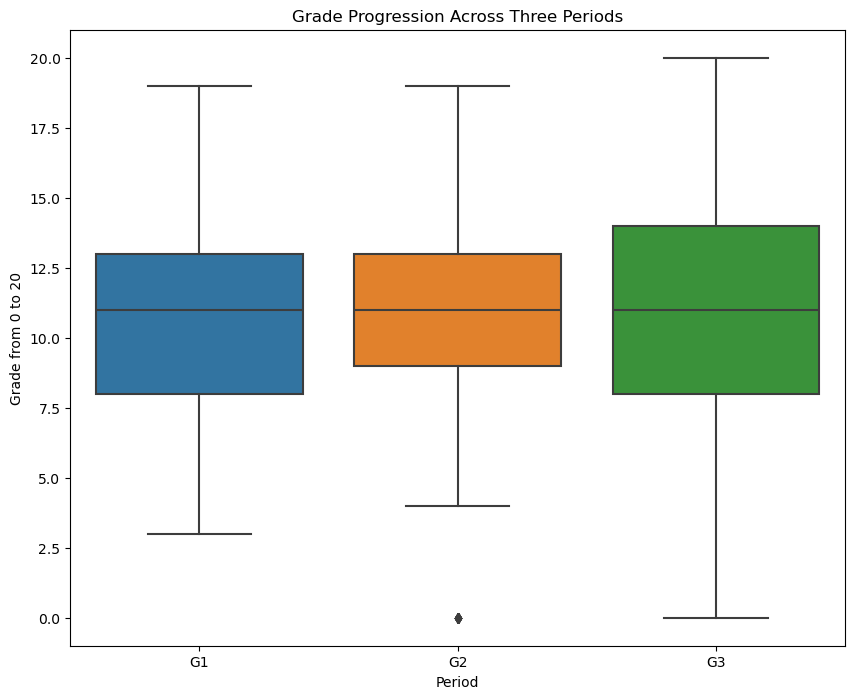

In [8]:
# boxplot for each grade period
grade_data = math_data[['G1', 'G2', 'G3']].melt(var_name='Period', value_name='Grade')
plt.figure(figsize=(10, 8))
sns.boxplot(x='Period', y='Grade', data=grade_data)
plt.title('Grade Progression Across Three Periods')
plt.ylabel('Grade from 0 to 20')
plt.show()

# Initial Metric Calculations

In [9]:
features = ['sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
           'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 
           'activities', 'higher', 'internet', 'romantic', 'famrel', 
           'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

X = pd.get_dummies(math_data[features], drop_first=True)
y = math_data['passed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Fit model on general data
scaler = StandardScaler()
model = LogisticRegression(C=1.0, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test_scaled)
prob_predictions = model.predict_proba(X_test_scaled)[:,1]


print(f"ROC-AUC: {roc_auc_score(y_test, prob_predictions):.4f}")
print(classification_report(y_test, predictions))
print("accuracy:", accuracy_score(y_test, predictions))

ROC-AUC: 0.7308
              precision    recall  f1-score   support

       False       0.64      0.33      0.44        27
        True       0.72      0.90      0.80        52

    accuracy                           0.71        79
   macro avg       0.68      0.62      0.62        79
weighted avg       0.70      0.71      0.68        79

accuracy: 0.7088607594936709


In [12]:
def get_confusion_stats(y_true, y_pred):
    tn = fp = fn = tp = 0
    for i in range(len(y_true)):
        if y_true[i] == 0 and y_pred[i] == 0:
            tn += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            fp += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            fn += 1
        else:
            tp += 1
    return tn, fp, fn, tp

def demographic_parity_diff(group1_metrics, group2_metrics):
    return abs(group1_metrics['positive_rate'] - group2_metrics['positive_rate'])

def predictive_parity_diff(group1_metrics, group2_metrics):
    return abs(group1_metrics['precision'] - group2_metrics['precision'])

In [13]:
def get_group_metrics(y_true, y_pred, y_prob, group_mask):
    group_y = y_true[group_mask]
    group_pred = y_pred[group_mask]
    group_prob = y_prob[group_mask]
    tn, fp, fn, tp = get_confusion_stats(group_y, group_pred)
    prevalence = sum(group_y) / len(group_y) if len(group_y) > 0 else 0
    pos_rate = sum(group_pred) / len(group_pred) if len(group_pred) > 0 else 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  
    
    gfpr = 1 / (fp + tn) * np.sum(group_prob[group_y == 0]) if (fp + tn) > 0 else 0
    gfnr = 1 / (fn + tp) * np.sum(1 - group_prob[group_y == 1]) if (fn + tp) > 0 else 0
    
    return {
        'positives': sum(group_pred),
        'total': len(group_pred),
        'prevalence': prevalence,
        'positive_rate': pos_rate,
        'tpr': tpr,
        'fpr': fpr, 
        'precision': ppv,
        'npv': npv,
        'gfpr': gfpr,
        'gfnr': gfnr
    }

In [14]:
# For gender attribute
males = math_data.loc[y_test.index, 'sex'] == 'M'
females = math_data.loc[y_test.index, 'sex'] == 'F'

X_test_scaled = scaler.transform(X_test)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

male_metrics = get_group_metrics(np.array(y_test), predictions, y_prob, males)
female_metrics = get_group_metrics(np.array(y_test), predictions, y_prob, females)

print("gender attribute:")
print(f"Prevalence Male: {male_metrics['prevalence']}")
print(f"Prevalence Female: {female_metrics['prevalence']}")
print(f"demographic parity diff: {demographic_parity_diff(male_metrics, female_metrics)}")
print(f"predictive parity diff: {predictive_parity_diff(male_metrics, female_metrics)}")
print(f"GFPR - Male: {male_metrics['gfpr']}, Female: {female_metrics['gfpr']}")
print(f"GFNR - Male: {male_metrics['gfnr']}, Female: {female_metrics['gfnr']}")
print(f"NPV - Male: {male_metrics['npv']}, Female: {female_metrics['npv']}")


gender attribute:
Prevalence Male: 0.7073170731707317
Prevalence Female: 0.6052631578947368
demographic parity diff: 0.037227214377406836
predictive parity diff: 0.13162878787878785
GFPR - Male: 0.5739079843976039, Female: 0.5975206460416252
GFNR - Male: 0.21207677973798789, Female: 0.2583750762882124
NPV - Male: 0.625, Female: 0.6666666666666666


In [15]:
# For address attribute
urban = math_data.loc[y_test.index, 'address'] == 'U'
rural = math_data.loc[y_test.index, 'address'] == 'R'

X_test_scaled = scaler.transform(X_test)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

urban_metrics = get_group_metrics(np.array(y_test), predictions, y_prob, urban)
rural_metrics = get_group_metrics(np.array(y_test), predictions, y_prob, rural)

print("address attribute:")
print(f"Prevalence Urban: {urban_metrics['prevalence']}")
print(f"Prevalence Rural: {rural_metrics['prevalence']}")
print(f"demographic parity diff: {demographic_parity_diff(urban_metrics, rural_metrics)}")
print(f"predictive parity diff: {predictive_parity_diff(urban_metrics, rural_metrics)}")
print(f"GFPR - Urban: {urban_metrics['gfpr']}, Rural: {rural_metrics['gfpr']}")
print(f"GFNR - Urban: {urban_metrics['gfnr']}, Rural: {rural_metrics['gfnr']}")
print(f"NPV - Urban: {urban_metrics['npv']}, Rural: {rural_metrics['npv']}")

address attribute:
Prevalence Urban: 0.6833333333333333
Prevalence Rural: 0.5789473684210527
demographic parity diff: 0.025438596491228038
predictive parity diff: 0.21301020408163263
GFPR - Urban: 0.5575738001907583, Rural: 0.6569754124714022
GFNR - Urban: 0.21543791040728844, Rural: 0.29635445821197326
NPV - Urban: 0.7272727272727273, Rural: 0.3333333333333333


In [16]:
# For internet attribute
has_internet = math_data.loc[y_test.index, 'internet'] == 'yes'
no_internet = math_data.loc[y_test.index, 'internet'] == 'no'

X_test_scaled = scaler.transform(X_test)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

has_internet_metrics = get_group_metrics(np.array(y_test), predictions, y_prob, has_internet)
no_internet_metrics = get_group_metrics(np.array(y_test), predictions, y_prob, no_internet)

print("internet attribute:")
print(f"Prevalence Yes: {has_internet_metrics['prevalence']}")
print(f"Prevalence No: {no_internet_metrics['prevalence']}")
print(f"demographic parity diff: {demographic_parity_diff(has_internet_metrics, no_internet_metrics)}")
print(f"predictive parity diff: {predictive_parity_diff(has_internet_metrics, no_internet_metrics)}")
print(f"GFPR - Yes: {has_internet_metrics['gfpr']}, No: {no_internet_metrics['gfpr']}")
print(f"GFNR - Yes: {has_internet_metrics['gfnr']}, No: {no_internet_metrics['gfnr']}")
print(f"NPV - Yes: {has_internet_metrics['npv']}, No: {no_internet_metrics['npv']}")

internet attribute:
Prevalence Yes: 0.671875
Prevalence No: 0.6
demographic parity diff: 0.028124999999999956
predictive parity diff: 0.0691823899371069
GFPR - Yes: 0.5901729623589093, No: 0.5760122156430882
GFNR - Yes: 0.21326466553473183, No: 0.3247191943374511
NPV - Yes: 0.6363636363636364, No: 0.6666666666666666


# Dataset Interventions

# Ideas to test:

* Reweighting (In processing)
* Excluding the sensitive attribute (dataset based)
* Building different models for males and females (In processing)
* Threshold Adjustment Implementation (Post Processing)

In [17]:
def print_original_metrics():
    print("ORIGINAL METRICS:")
    print("gender attribute:")
    print(f"Prevalence Male: {male_metrics['prevalence']}")
    print(f"Prevalence Female: {female_metrics['prevalence']}")
    print(f"demographic parity diff: {demographic_parity_diff(male_metrics, female_metrics)}")
    print(f"predictive parity diff: {predictive_parity_diff(male_metrics, female_metrics)}")
    print(f"GFPR - Male: {male_metrics['gfpr']}, Female: {female_metrics['gfpr']}")
    print(f"GFNR - Male: {male_metrics['gfnr']}, Female: {female_metrics['gfnr']}")
    print(f"NPV - Male: {male_metrics['npv']}, Female: {female_metrics['npv']}")


In [18]:
def calculate_adjusted_metrics(y_true, y_pred, y_prob, male_mask, female_mask):
    y_true_np = np.array(y_true)
    y_pred_np = np.array(y_pred)
    y_prob_np = np.array(y_prob)
    male_mask_np = np.array(male_mask)
    female_mask_np = np.array(female_mask)
    
    male_metrics = get_group_metrics(y_true_np, y_pred_np, y_prob_np, male_mask_np)
    female_metrics = get_group_metrics(y_true_np, y_pred_np, y_prob_np, female_mask_np)
    dp_diff = demographic_parity_diff(male_metrics, female_metrics)
    pp_diff = predictive_parity_diff(male_metrics, female_metrics)
    
    print("\n\nNEW METRICS:")
    print(f"Prevalence Male: {male_metrics['prevalence']}")
    print(f"Prevalence Female: {female_metrics['prevalence']}")
    print(f"demographic parity diff: {dp_diff}")
    print(f"predictive parity diff: {pp_diff}")
    print(f"GFPR - Male: {male_metrics['gfpr']}, Female: {female_metrics['gfpr']}")
    print(f"GFNR - Male: {male_metrics['gfnr']}, Female: {female_metrics['gfnr']}")
    print(f"NPV - Male: {male_metrics['npv']}, Female: {female_metrics['npv']}")
    print("\n")    
    return male_metrics, female_metrics

In [19]:
def calculate_adjusted_metrics_with_thresholds(y_true, y_prob, male_mask, female_mask, male_threshold, female_threshold):
   y_true_np = np.array(y_true)
   y_prob_np = np.array(y_prob)
   male_mask_np = np.array(male_mask)
   female_mask_np = np.array(female_mask)
   
   y_pred_np = np.zeros_like(y_true_np)
   y_pred_np[male_mask_np] = (y_prob_np[male_mask_np] >= male_threshold).astype(int)
   y_pred_np[female_mask_np] = (y_prob_np[female_mask_np] >= female_threshold).astype(int)
   
   male_metrics = get_group_metrics(y_true_np, y_pred_np, y_prob_np, male_mask_np)
   female_metrics = get_group_metrics(y_true_np, y_pred_np, y_prob_np, female_mask_np)
   
   dp_diff = demographic_parity_diff(male_metrics, female_metrics)
   pp_diff = predictive_parity_diff(male_metrics, female_metrics)
   
   print("\n\nADJUSTED METRICS WITH THRESHOLDS:")
   print(f"Male threshold: {male_threshold}, Female threshold: {female_threshold}")
   print(f"Prevalence Male: {male_metrics['prevalence']}")
   print(f"Prevalence Female: {female_metrics['prevalence']}")
   print(f"demographic parity diff: {dp_diff}")
   print(f"predictive parity diff: {pp_diff}")
   print(f"GFPR - Male: {male_metrics['gfpr']}, Female: {female_metrics['gfpr']}")
   print(f"GFNR - Male: {male_metrics['gfnr']}, Female: {female_metrics['gfnr']}")
   print(f"NPV - Male: {male_metrics['npv']}, Female: {female_metrics['npv']}")
   print("\n")    
   
   return male_metrics, female_metrics

# Reweighting Approach

In [20]:
model = LogisticRegression(C=1, max_iter=1000)
model.fit(X_train, y_train)
y_pred_original = model.predict(X_test)
y_prob_original = model.predict_proba(X_test)[:, 1]

In [21]:
male_test_mask = X_test['sex_M'] == 1
female_test_mask = X_test['sex_M'] == 0
male_mask = X_train['sex_M'] == 1
female_mask = X_train['sex_M'] == 0

male_metrics = get_group_metrics(np.array(y_test), np.array(y_pred_original), 
                               np.array(y_prob_original), np.array(male_test_mask))
female_metrics = get_group_metrics(np.array(y_test), np.array(y_pred_original), 
                                 np.array(y_prob_original), np.array(female_test_mask))


In [22]:
p_male = male_mask.mean()
p_female = female_mask.mean()
p_y_1 = y_train.mean()
p_y_0 = 1 - p_y_1

In [23]:
p_male_pos = ((male_mask) & (y_train == 1)).mean()
p_male_neg = ((male_mask) & (y_train == 0)).mean()
p_female_pos = ((female_mask) & (y_train == 1)).mean()
p_female_neg = ((female_mask) & (y_train == 0)).mean()


In [24]:
weights = pd.Series(index=X_train.index, data=np.ones(len(X_train)))

weights[male_mask & (y_train == 1)] = 1.5 * (p_y_1 * p_male / p_male_pos)
weights[male_mask & (y_train == 0)] = 0.5 * (p_y_0 * p_male / p_male_neg)
weights[female_mask & (y_train == 1)] = 1.5 * (p_y_1 * p_female / p_female_pos)
weights[female_mask & (y_train == 0)] = 0.5 * (p_y_0 * p_female / p_female_neg)

In [25]:
model_weighted = LogisticRegression(C=1, max_iter=1000)
model_weighted.fit(X_train, y_train, sample_weight=weights)

y_pred_reweighted = model_weighted.predict(X_test)
y_prob_reweighted = model_weighted.predict_proba(X_test)[:, 1]


In [26]:
print_original_metrics()

reweighted_male_metrics, reweighted_female_metrics = calculate_adjusted_metrics(
    y_test, y_pred_reweighted, y_prob_reweighted, male_test_mask, female_test_mask
)

ORIGINAL METRICS:
gender attribute:
Prevalence Male: 0.7073170731707317
Prevalence Female: 0.6052631578947368
demographic parity diff: 0.037227214377406836
predictive parity diff: 0.13162878787878785
GFPR - Male: 0.5675003660786816, Female: 0.596437802520307
GFNR - Male: 0.21411375950565711, Female: 0.25977885795888894
NPV - Male: 0.625, Female: 0.6666666666666666


NEW METRICS:
Prevalence Male: 0.7073170731707317
Prevalence Female: 0.6052631578947368
demographic parity diff: 0.018613607188703418
predictive parity diff: 0.10115830115830116
GFPR - Male: 0.7189003537006872, Female: 0.7884629310180532
GFNR - Male: 0.11743512731947069, Female: 0.11966302187404804
NPV - Male: 0.5, Female: 0.6666666666666666




# Drop the Sensitive Attribute (gender)

In [27]:
model = LogisticRegression(C=1, max_iter=1000)
model.fit(X_train, y_train)
y_pred_original = model.predict(X_test)
y_prob_original = model.predict_proba(X_test)[:, 1]

male_test_mask = X_test['sex_M'] == 1
female_test_mask = X_test['sex_M'] == 0

In [28]:
male_metrics = get_group_metrics(np.array(y_test), np.array(y_pred_original), 
                               np.array(y_prob_original), np.array(male_test_mask))
female_metrics = get_group_metrics(np.array(y_test), np.array(y_pred_original), 
                                 np.array(y_prob_original), np.array(female_test_mask))


In [29]:
X_train_no_gender = X_train.drop(columns=['sex_M'])
X_test_no_gender = X_test.drop(columns=['sex_M'])

model_no_gender = LogisticRegression(C=1, max_iter=1000)
model_no_gender.fit(X_train_no_gender, y_train)

y_pred_no_gender = model_no_gender.predict(X_test_no_gender)
y_prob_no_gender = model_no_gender.predict_proba(X_test_no_gender)[:, 1]


In [30]:
print_original_metrics()

no_gender_male_metrics, no_gender_female_metrics = calculate_adjusted_metrics(
    y_test, y_pred_no_gender, y_prob_no_gender, male_test_mask, female_test_mask
)

ORIGINAL METRICS:
gender attribute:
Prevalence Male: 0.7073170731707317
Prevalence Female: 0.6052631578947368
demographic parity diff: 0.037227214377406836
predictive parity diff: 0.13162878787878785
GFPR - Male: 0.5675003660786816, Female: 0.596437802520307
GFNR - Male: 0.21411375950565711, Female: 0.25977885795888894
NPV - Male: 0.625, Female: 0.6666666666666666


NEW METRICS:
Prevalence Male: 0.7073170731707317
Prevalence Female: 0.6052631578947368
demographic parity diff: 0.08793324775353017
predictive parity diff: 0.14583333333333337
GFPR - Male: 0.5287266412424629, Female: 0.619465869844316
GFNR - Male: 0.23838867754780155, Female: 0.2356288179318616
NPV - Male: 0.6666666666666666, Female: 0.8




# Running Gender Models Separately

In [31]:
model = LogisticRegression(C=1, max_iter=1000)
model.fit(X_train, y_train)
y_pred_original = model.predict(X_test)
y_prob_original = model.predict_proba(X_test)[:, 1]

In [32]:
male_test_mask = X_test['sex_M'] == 1
female_test_mask = X_test['sex_M'] == 0

male_metrics = get_group_metrics(np.array(y_test), np.array(y_pred_original), 
                               np.array(y_prob_original), np.array(male_test_mask))
female_metrics = get_group_metrics(np.array(y_test), np.array(y_pred_original), 
                                 np.array(y_prob_original), np.array(female_test_mask))


X_train_male = X_train[X_train['sex_M'] == 1]
y_train_male = y_train[X_train_male.index]
X_train_female = X_train[X_train['sex_M'] == 0]
y_train_female = y_train[X_train_female.index]

In [33]:
male_model = LogisticRegression(C=1, max_iter=1000)
male_model.fit(X_train_male, y_train_male)

female_model = LogisticRegression(C=1, max_iter=1000)
female_model.fit(X_train_female, y_train_female)

X_test_male = X_test[X_test['sex_M'] == 1]
y_test_male = y_test[X_test_male.index]

In [34]:
male_preds = male_model.predict(X_test_male)
male_probs = male_model.predict_proba(X_test_male)[:, 1]

X_test_female = X_test[X_test['sex_M'] == 0]
y_test_female = y_test[X_test_female.index]

female_preds = female_model.predict(X_test_female)
female_probs = female_model.predict_proba(X_test_female)[:, 1]

In [35]:
y_pred_separate = pd.Series(index=y_test.index)
y_pred_separate.loc[X_test_male.index] = male_preds
y_pred_separate.loc[X_test_female.index] = female_preds
y_prob_separate = pd.Series(index=y_test.index)
y_prob_separate.loc[X_test_male.index] = male_probs
y_prob_separate.loc[X_test_female.index] = female_probs

/var/folders/6b/tjs8kbdd0xs_wt3p6hdmsb4r0000gn/T/ipykernel_82964/440832276.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False  True False False  True  True  True  True  True  True False  True
  True  True  True  True  True  True False False  True  True False  True
 False  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  y_pred_separate.loc[X_test_male.index] = male_preds


In [36]:
print_original_metrics()

separate_male_metrics, separate_female_metrics = calculate_adjusted_metrics(
    y_test, y_pred_separate, y_prob_separate, male_test_mask, female_test_mask
)

ORIGINAL METRICS:
gender attribute:
Prevalence Male: 0.7073170731707317
Prevalence Female: 0.6052631578947368
demographic parity diff: 0.037227214377406836
predictive parity diff: 0.13162878787878785
GFPR - Male: 0.5675003660786816, Female: 0.596437802520307
GFNR - Male: 0.21411375950565711, Female: 0.25977885795888894
NPV - Male: 0.625, Female: 0.6666666666666666


NEW METRICS:
Prevalence Male: 0.7073170731707317
Prevalence Female: 0.6052631578947368
demographic parity diff: 0.11232349165596922
predictive parity diff: 0.17204301075268824
GFPR - Male: 0.526237714784872, Female: 0.5821688454866234
GFNR - Male: 0.19065655152860425, Female: 0.28694149823689347
NPV - Male: 0.7, Female: 0.8




# Threshold Adjustment Implementation

In [37]:
model = LogisticRegression(C=1, max_iter=1000)
model.fit(X_train, y_train)
y_pred_original = model.predict(X_test)
y_prob_original = model.predict_proba(X_test)[:, 1]

In [38]:
male_test_mask = X_test['sex_M'] == 1
female_test_mask = X_test['sex_M'] == 0

male_metrics = get_group_metrics(np.array(y_test), np.array(y_pred_original), 
                              np.array(y_prob_original), np.array(male_test_mask))
female_metrics = get_group_metrics(np.array(y_test), np.array(y_pred_original), 
                                np.array(y_prob_original), np.array(female_test_mask))



In [39]:
def get_tpr_fpr(y_true, y_scores, threshold, mask):
   y_pred = (y_scores >= threshold).astype(int)
   
   true_pos = np.sum((y_true[mask] == 1) & (y_pred[mask] == 1))
   false_pos = np.sum((y_true[mask] == 0) & (y_pred[mask] == 1))
   
   total_pos = np.sum(y_true[mask] == 1)
   total_neg = np.sum(y_true[mask] == 0)
   
   tpr = true_pos / total_pos if total_pos > 0 else 0
   fpr = false_pos / total_neg if total_neg > 0 else 0
   return tpr, fpr

male_tpr, male_fpr = get_tpr_fpr(y_test, y_prob_original, 0.5, male_test_mask)
female_tpr, female_fpr = get_tpr_fpr(y_test, y_prob_original, 0.5, female_test_mask)


In [40]:
male_thresholds = np.linspace(0.3, 0.7, 9)
female_thresholds = np.linspace(0.3, 0.7, 9)

best_male_thresh = 0.5
best_female_thresh = 0.5
min_dp_diff = float('inf')

In [41]:
for m_thresh in male_thresholds:
   for f_thresh in female_thresholds:
       temp_male_pred = (y_prob_original[male_test_mask] >= m_thresh).astype(int)
       temp_female_pred = (y_prob_original[female_test_mask] >= f_thresh).astype(int)
       
       male_pos_rate = np.mean(temp_male_pred)
       female_pos_rate = np.mean(temp_female_pred)
       
       dp_diff = abs(male_pos_rate - female_pos_rate)
       
       if dp_diff < min_dp_diff:
           min_dp_diff = dp_diff
           best_male_thresh = m_thresh
           best_female_thresh = f_thresh

print_original_metrics()

adjusted_male_metrics, adjusted_female_metrics = calculate_adjusted_metrics_with_thresholds(
   y_test, y_prob_original, male_test_mask, female_test_mask, best_male_thresh, best_female_thresh
)


ORIGINAL METRICS:
gender attribute:
Prevalence Male: 0.7073170731707317
Prevalence Female: 0.6052631578947368
demographic parity diff: 0.037227214377406836
predictive parity diff: 0.13162878787878785
GFPR - Male: 0.5675003660786816, Female: 0.596437802520307
GFNR - Male: 0.21411375950565711, Female: 0.25977885795888894
NPV - Male: 0.625, Female: 0.6666666666666666


ADJUSTED METRICS WITH THRESHOLDS:
Male threshold: 0.3, Female threshold: 0.35
Prevalence Male: 0.7073170731707317
Prevalence Female: 0.6052631578947368
demographic parity diff: 0.007702182284980763
predictive parity diff: 0.08267090620031792
GFPR - Male: 0.5675003660786816, Female: 0.596437802520307
GFNR - Male: 0.21411375950565711, Female: 0.25977885795888894
NPV - Male: 0.5, Female: 0.75




# Research Paper Implementation - Uniform Sampling

In [105]:
df = pd.concat([X_train, pd.Series(y_train, index=X_train.index, name='target')], axis=1)

protected_attribute = 'sex_M'
privileged_value = 1
unprivileged_value = 0

df['target'] = df['target'].astype(bool).astype(int)


In [106]:
dp_mask = (df[protected_attribute] == unprivileged_value) & (df['target'] == 1)
dn_mask = (df[protected_attribute] == unprivileged_value) & (df['target'] == 0)
fp_mask = (df[protected_attribute] == privileged_value) & (df['target'] == 1)
fn_mask = (df[protected_attribute] == privileged_value) & (df['target'] == 0)

dp = df[dp_mask]
dn = df[dn_mask]
fp = df[fp_mask]
fn = df[fn_mask]

dp_size = len(dp)
dn_size = len(dn)
fp_size = len(fp)
fn_size = len(fn)
total_size = len(df)

In [107]:
privileged_count = fp_size + fn_size
unprivileged_count = dp_size + dn_size
overall_pos_rate = (dp_size + fp_size) / total_size

target_dp_size = int(unprivileged_count * overall_pos_rate)
target_dn_size = unprivileged_count - target_dp_size
target_fp_size = int(privileged_count * overall_pos_rate)
target_fn_size = privileged_count - target_fp_size


In [108]:
if target_dp_size > dp_size:
    indices = np.random.choice(dp.index, size=target_dp_size - dp_size, replace=True)
    additional_rows = dp.loc[indices]
    dp_resampled = pd.concat([dp, additional_rows])
elif target_dp_size < dp_size:
    indices = np.random.choice(dp.index, size=target_dp_size, replace=False)
    dp_resampled = dp.loc[indices]
else:
    dp_resampled = dp

if target_dn_size > dn_size:
    indices = np.random.choice(dn.index, size=target_dn_size - dn_size, replace=True)
    additional_rows = dn.loc[indices]
    dn_resampled = pd.concat([dn, additional_rows])
elif target_dn_size < dn_size:
    indices = np.random.choice(dn.index, size=target_dn_size, replace=False)
    dn_resampled = dn.loc[indices]
else:
    dn_resampled = dn

if target_fp_size > fp_size:
    indices = np.random.choice(fp.index, size=target_fp_size - fp_size, replace=True)
    additional_rows = fp.loc[indices]
    fp_resampled = pd.concat([fp, additional_rows])
elif target_fp_size < fp_size:
    indices = np.random.choice(fp.index, size=target_fp_size, replace=False)
    fp_resampled = fp.loc[indices]
else:
    fp_resampled = fp

if target_fn_size > fn_size:
    indices = np.random.choice(fn.index, size=target_fn_size - fn_size, replace=True)
    additional_rows = fn.loc[indices]
    fn_resampled = pd.concat([fn, additional_rows])
elif target_fn_size < fn_size:
    indices = np.random.choice(fn.index, size=target_fn_size, replace=False)
    fn_resampled = fn.loc[indices]
else:
    fn_resampled = fn

In [109]:
df_resampled = pd.concat([dp_resampled, dn_resampled, fp_resampled, fn_resampled])
X_us = df_resampled.drop(['target'], axis=1)
y_us = df_resampled['target'].astype(int)

model_us = LogisticRegression(C=1, max_iter=1000)
model_us.fit(X_us, y_us)
y_pred_us = model_us.predict(X_test)
y_prob_us = model_us.predict_proba(X_test)[:, 1]

male_test_mask = X_test['sex_M'] == 1
female_test_mask = X_test['sex_M'] == 0


print_original_metrics()

male_metrics_us, female_metrics_us = calculate_adjusted_metrics(
    y_test, y_pred_us, y_prob_us, male_test_mask, female_test_mask
)

ORIGINAL METRICS:
gender attribute:
Prevalence Male: 0.7073170731707317
Prevalence Female: 0.6052631578947368
demographic parity diff: 0.037227214377406836
predictive parity diff: 0.13162878787878785
GFPR - Male: 0.5675003660786816, Female: 0.596437802520307
GFNR - Male: 0.21411375950565711, Female: 0.25977885795888894
NPV - Male: 0.625, Female: 0.6666666666666666


NEW METRICS:
Prevalence Male: 0.7073170731707317
Prevalence Female: 0.6052631578947368
demographic parity diff: 0.06354300385109113
predictive parity diff: 0.1515151515151516
GFPR - Male: 0.534641227552799, Female: 0.6089191071819573
GFNR - Male: 0.2268733298889819, Female: 0.24462587290137935
NPV - Male: 0.75, Female: 0.8


